In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle

sys.path.append('..')

In [4]:
import seaborn as sns
import matplotlib.style as style

In [5]:
from pals.evaluation import evaluate_performance
from pals.common import *

In [6]:
style.use('seaborn-poster') # sets the size of the charts
sns.set_context('poster') # everything is larger

# HAT Data Evaluation

This notebook is used to compute precision, recall and F-1 scores on the HAT data for the manuscript.

In [7]:
results = load_obj(os.path.join('test_data', 'HAT', 'HAT_results.p'))

2019-11-29 17:05:31.140 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-11-29 17:05:31.141 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-11-29 17:05:32.212 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


### Plasma

In [8]:
experiment_name = 'plasma'
threshold = 0.05
N = 20
df = evaluate_performance(results, experiment_name, threshold, N)
df

2019-11-29 17:05:51.338 | DEBUG    | pals.evaluation:evaluate_performance:77 - Generating PALS full results
2019-11-29 17:05:51.343 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:323 - Setting the zero intensity values in the dataframe
2019-11-29 17:05:51.424 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:304 - Scaling the data across the sample: zero mean and unit variance
2019-11-29 17:05:51.483 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:143 - Mean values of the rows in the DF is [ 0. -0.  0. ... -0. -0. -0.]
2019-11-29 17:05:51.484 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:144 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2019-11-29 17:05:53.520 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:155 - Calculating plage p-values with resampling
2019-11-29 17:05:53.520 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:159 - Comparison Stage2/Stage1
2019-11-29 17:05:53.521 | DEBUG    | pals.pathw

,method,n_sample,i,TP,FP,FN,precision,recall,F1
0,PALS,4,0,0,1,20,0.000000,0.00,0.000000
1,PALS,4,1,2,0,18,1.000000,0.10,0.181818
2,PALS,4,2,4,1,16,0.800000,0.20,0.320000
3,PALS,4,3,0,1,20,0.000000,0.00,0.000000
4,PALS,4,4,3,9,17,0.250000,0.15,0.187500
...,...,...,...,...,...,...,...,...,...
295,PALS,12,95,16,4,4,0.800000,0.80,0.800000
296,PALS,12,96,17,3,3,0.850000,0.85,0.850000
297,PALS,12,97,17,1,3,0.944444,0.85,0.894737
298,PALS,12,98,15,5,5,0.750000,0.75,0.750000


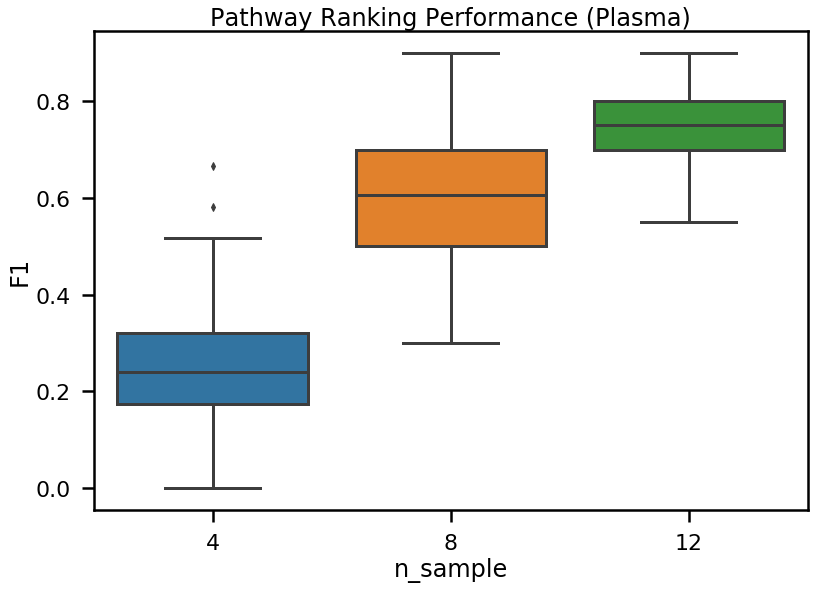

In [9]:
sns.boxplot(x='n_sample', y='F1', data=df)
plt.title('Pathway Ranking Performance (Plasma)')
plt.savefig(os.path.join('test_data', 'HAT', 'evaluation_plasma.eps'), dpi=300)

### CSF

In [10]:
experiment_name = 'csf'
threshold = 0.05
N = 20
df = evaluate_performance(results, experiment_name, threshold, N)
df

2019-11-29 17:05:58.840 | DEBUG    | pals.evaluation:evaluate_performance:77 - Generating PALS full results
2019-11-29 17:05:58.844 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:323 - Setting the zero intensity values in the dataframe
2019-11-29 17:05:58.897 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:304 - Scaling the data across the sample: zero mean and unit variance
2019-11-29 17:05:58.961 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:143 - Mean values of the rows in the DF is [ 0.  0.  0. ... -0. -0. -0.]
2019-11-29 17:05:58.965 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:144 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2019-11-29 17:06:00.931 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:155 - Calculating plage p-values with resampling
2019-11-29 17:06:00.932 | DEBUG    | pals.pathway_analysis:set_up_resample_plage_p_df:159 - Comparison Stage_1/Stage_2
2019-11-29 17:06:00.932 | DEBUG    | pals.pat

,method,n_sample,i,TP,FP,FN,precision,recall,F1
0,PALS,4,0,1,0,19,1.000000,0.05,0.095238
1,PALS,4,1,7,7,13,0.500000,0.35,0.411765
2,PALS,4,2,1,1,19,0.500000,0.05,0.090909
3,PALS,4,3,4,2,16,0.666667,0.20,0.307692
4,PALS,4,4,5,0,15,1.000000,0.25,0.400000
...,...,...,...,...,...,...,...,...,...
295,PALS,12,95,12,8,8,0.600000,0.60,0.600000
296,PALS,12,96,16,4,4,0.800000,0.80,0.800000
297,PALS,12,97,15,5,5,0.750000,0.75,0.750000
298,PALS,12,98,15,5,5,0.750000,0.75,0.750000


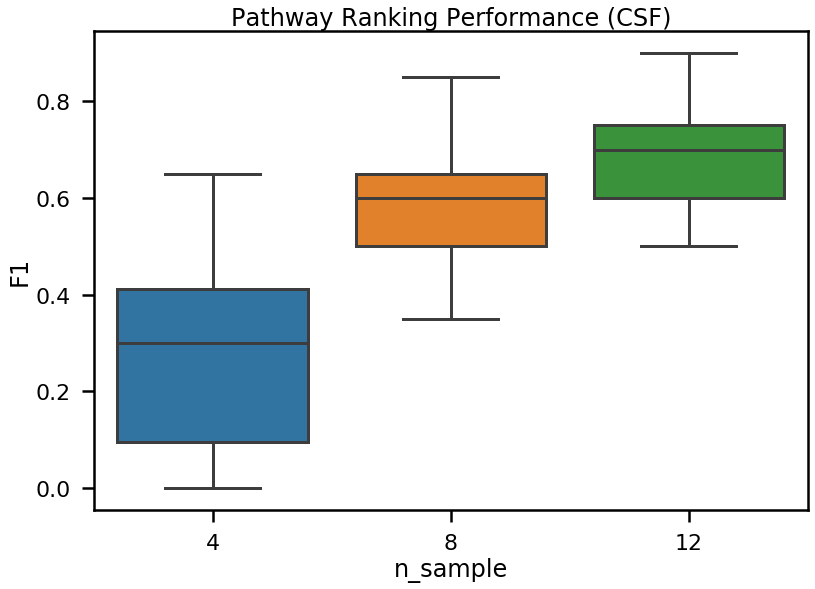

In [11]:
sns.boxplot(x='n_sample', y='F1', data=df)
plt.title('Pathway Ranking Performance (CSF)')
plt.savefig(os.path.join('test_data', 'HAT', 'evaluation_csf.eps'), dpi=300)